# Polygon point generation function

### Used for generating points for either the Rx array or a Tx array for making a LUT

In [1]:
function regularPoly(n,r,center)
    a = 0; b = 0;
    points = zeros(n,2);
    points[1,1], points[1,2] = a, b+r;  
    theta = pi/2
    dTheta = 2*pi/n

    for i in 2:n
        theta += dTheta
        points[i,1],points[i,2] = a + r*cos(theta), b + r*sin(theta)
    end

    offsetX = -center;
    offsety = -center;

    for i in 1:n
            theta += dTheta
            points[i,1],points[i,2] = points[i,1] - offsetX,points[i,2] - offsety;
    end


    return points
    end

regularPoly (generic function with 1 method)

### Function to convert matrix generated like as it is done inthe function above to a vector

In [2]:
function matToVector(mat)
    len = length(mat)/2;
    len = convert(UInt32,len)
    items = [zeros(3) for _ in 1:len]
    for i in 1:len
        items[i][1],items[i][2] = mat[i,1],mat[i,2]; 
    end
    
    return items
    

end


matToVector (generic function with 1 method)

### Convert to tuple list for some other functions I made

In [3]:
function matToTupleList(mat)
    len = length(mat)/2;
    len = convert(UInt32,len)
    tuples = mat[1,1],mat[1,2];
    for i in 2:len
        tuples = cat(tuples,(mat[i,1], mat[i,2]),dims=1)
    end
    
    return tuples
    
end
    

matToTupleList (generic function with 1 method)

# Parameters and setup for testing

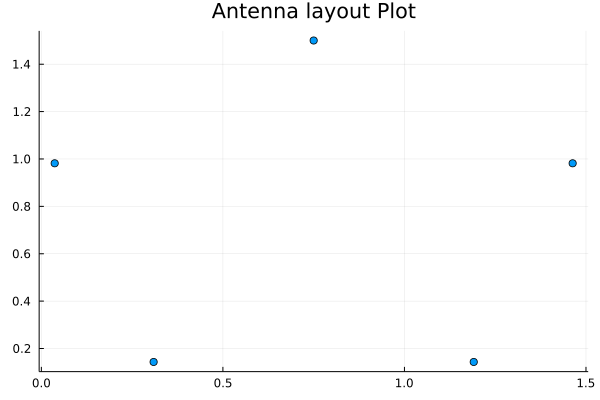

In [4]:
c = 3e8;
f = 100e6;
λ = c/f

r = λ/4;
numAntennas = 5;
antennaLayout = regularPoly(numAntennas,r,r)
AL = matToTupleList(antennaLayout)
ALv = matToVector(antennaLayout)
RadioSource = -200,-100;
RadioSourceV = [-200,-100]

using Plots
plot(antennaLayout[:,1], antennaLayout[:,2], seriestype = :scatter, title = "Antenna layout Plot",legend=false)


# Analytical angle of arrival using vectors

#### Used to determine the correct AoA for generating a simulated LUTs truth values

In [6]:
function AngleV(Rx,Tx)
    
    ref = [1,0,0];
    dif = Tx-Rx;
    θ= acos(clamp(ref⋅dif/(norm(ref)*norm(dif)), -1, 1))
    
    offset = 0;
    if Tx[2]<=Rx[2]
        offset = 2*pi;
       # println("offset 3/4")
    else 
       # println("offset 1/2")
    end
    return abs(offset-θ) 
end

AngleV (generic function with 1 method)

# Determine angle between two antenna simulation

### Function for distance between two points

In [7]:
function distance(a,b)
   return sqrt((a[1]-b[1])^2+(a[2]-b[2])^2);
end

distance (generic function with 1 method)

In [8]:
function distanceV(a,b)
   return norm(a-b)
end

distanceV (generic function with 1 method)

### Function for time delay between two points

In [9]:
function tV(a,b)
   return distanceV(a,b)/c; 
end

tV (generic function with 1 method)

In [10]:
function ΔtV(Rx1,Rx2,src)
    
    return tV(Rx1,src)-tV(Rx2,src)
end

ΔtV (generic function with 1 method)

### Function for time delay based on frequency/wavelength

In [11]:
function Δtλ(Rx1,Rx2,src,freq,c)
    λ=c/freq;
    phase1 = (distanceV(Rx1,src)%λ)/λ;#phase as a fraction of a full wavelength
    phase2 = (distanceV(Rx2,src)%λ)/λ;#phase as a fraction of a full wavelength
    Δphase = angle(ℯ^(im*2pi*phase1)*conj(ℯ^(im*2pi*phase2))) #Account for phase wrapping using a complex exponential
    return   λ*Δphase/(2π*c)    
end

Δtλ (generic function with 1 method)

In [12]:
function Δtλ(Rx1,Rx2,src,freq,c)
    errThreshold = 0.9 #The fraction of the maximum Δphase required for reflection errors to occur due to mutual coupling
    errSize = 5 # a divisor for the maximum phase used to determine the maximum magnitude of the noise
    λ=c/freq;
   maxphase = 2*pi*(distanceV(Rx1,Rx2))/λ; #max Δphase
    
    phase1 = (distanceV(Rx1,src)%λ)/λ;#phase as a fraction of a full wavelength
    phase2 = (distanceV(Rx2,src)%λ)/λ;#phase as a fraction of a full wavelength
    Δphase = angle(ℯ^(im*2*pi*phase1)*conj(ℯ^(im*2pi*phase2)))
    
    if(abs((Δphase)/maxphase)>errThreshold)
        errReflection = (maxphase/errSize)*rand()-maxphase/(2*errSize); #Add a random error when the antennas get in eachothers way/occlude eachother
    else 
        errReflection = 0
    end
    errNoise= maxphase/(2*errSize)*rand()-maxphase/(4*errSize)
    
    return   λ*(Δphase+errReflection+errNoise)/(2*pi*c)    
end

Δtλ (generic function with 1 method)

In [13]:
function Δλ(Rx1,Rx2,src,freq,c)
    errThreshold = 0.9 #The fraction of the maximum Δphase required for reflection errors to occur due to mutual coupling
    errSize = 5
    λ=c/freq;
    maxphase = (distanceV(Rx1,Rx2))/λ; #max Δphase as a fraction of a full wavelength
    Δphase = (distanceV(Rx1,src)-distanceV(Rx2,src))/λ
    
    if(abs((Δphase)/maxphase)>errThreshold)
        errReflection = (maxphase/errSize)*rand()-maxphase/(2*errSize); #Add a random error when the antennas get in eachothers way
    else 
        errReflection = 0
    end
    errNoise= maxphase/(2*errSize)*rand()-maxphase/(4*errSize)
    return (Δphase+errReflection+errNoise)*2pi
end

Δλ (generic function with 1 method)

# Function to generate readings from Antenna array

In [15]:
function measureAntennaArray(AntennaLayout,src,freq)
    numAntennas = length(AntennaLayout)
    row = zeros(convert(UInt32,((numAntennas-1)*(numAntennas)//2)));
    index = 1;
    for n in 1:numAntennas-1
        for i in n+1:numAntennas
            row[index] = Δtλ(AntennaLayout[n],AntennaLayout[i],src,freq,3e8) ;
            index+=1;
        end
    end
    return row
end


measureAntennaArray (generic function with 1 method)

# The same as the measureAntennaArray except that it takes fewer time delay measurements

In [16]:
function measureAntennaArrayReduced(AntennaLayout,src,freq)
    
    numAntennas = length(AntennaLayout)
    row = zeros(numAntennas-1);
    index = 1;
    for n in 2:numAntennas
            row[index] = Δtλ(AntennaLayout[1],AntennaLayout[n],src,freq,3e8) ;
        index+=1;
        end
    return row
end


measureAntennaArrayReduced (generic function with 1 method)

# Generate LUTs

In [18]:
function generateLUT(Rx,src,r,freq)
    
    numAntennas = length(Rx)
    LUT = [zeros(numAntennas-1) for _ in 1:length(src)]
    
    #row = zeros(numAntennas-1);
    for i in 1:length(src) 
    
        LUT[i]=measureAntennaArray(Rx,src[i],freq);
    end
    
    TrueValues = zeros(360);
    for i in  1:360
        TrueValues[i] = (AngleV([r,r,0],src[i])*180/pi)
    end
    
    return LUT, TrueValues
    
    
    S
    
end

generateLUT (generic function with 1 method)

In [19]:
function generateLUTReduced(Rx,src,r,freq)
    
    numAntennas = length(Rx)
    LUT = [zeros(numAntennas-1) for _ in 1:length(src)]
    
    #row = zeros(numAntennas-1);
    for i in 1:length(src) 
    
        LUT[i]=measureAntennaArrayReduced(Rx,src[i],freq);
    end
    
    TrueValues = zeros(36);
    for i in  10:10:360
        TrueValues[div(i,10)] = (AngleV([r,r,0],src[div(i,10)])*180/pi)
    end
    
    return LUT, TrueValues
    
    
    
    
end

generateLUTReduced (generic function with 1 method)

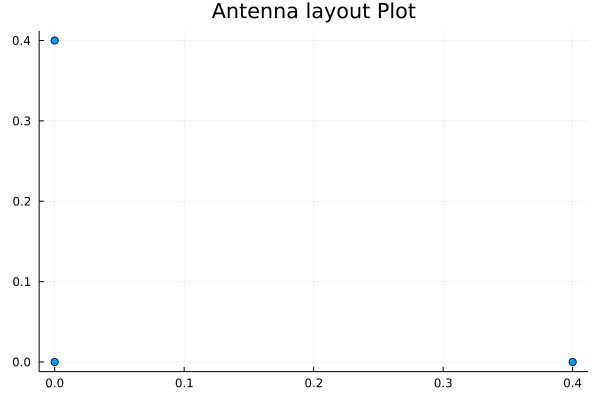

In [20]:
c = 3e8;
f = 89e6;
λ = c/f
r = λ/4;
numAntennas = 3 

RadioSources = regularPoly(36,1000,r)
RadioSourcesV = matToVector(RadioSources)

ALv = [[0,0,0],[0,0.4,0],[0.4,0,0]] #custom antenna array layout
#AntennaLayout = regularPoly(numAntennas,r,r)
#ALv = matToVector(AntennaLayout)



l,t = generateLUTReduced(ALv,RadioSourcesV,r,f);

layoutx=zeros(length(ALv))
layouty=zeros(length(ALv))
for i=1:length(ALv)
    layoutx[i]=ALv[i][1]
    layouty[i]=ALv[i][2]
end
    

plot(layoutx, layouty, seriestype = :scatter, title = "Antenna layout Plot",legend=false)


# MSE function

In [21]:
function MSE(x,y)
    n = minimum([length(x),length(y)]);
    total=0;
    for i in 1:n
        total+=(x[i]-y[i])^2;
    end
    
    return total/n
    
    
end

MSE (generic function with 1 method)

In [22]:
function MSE2(x,y)
   return sum((x.-y).^2)/length(x)
end

MSE2 (generic function with 1 method)

In [23]:
@show MSE([1,2,3,4],[4,5,6,7])
@show MSE2([1,2,3,4],[4,5,6,7])

MSE([1, 2, 3, 4], [4, 5, 6, 7]) = 9.0
MSE2([1, 2, 3, 4], [4, 5, 6, 7]) = 9.0


9.0



# Correlate direction against LUT

In [24]:
function LookUpAngle(LUT,Truth,measurement)
    
    maxcor = 2^32;
    maxcorindex = 1;
    LOSS = zeros(length(LUT))
       for i in 1:length(LUT)
        value = MSE(LUT[i],measurement);
        LOSS[i]= value;
        if value<maxcor
            maxcor = value;
            maxcorindex = i;
            
        end
        
    end
    
    return Truth[maxcorindex],LOSS
    
end

LookUpAngle (generic function with 1 method)

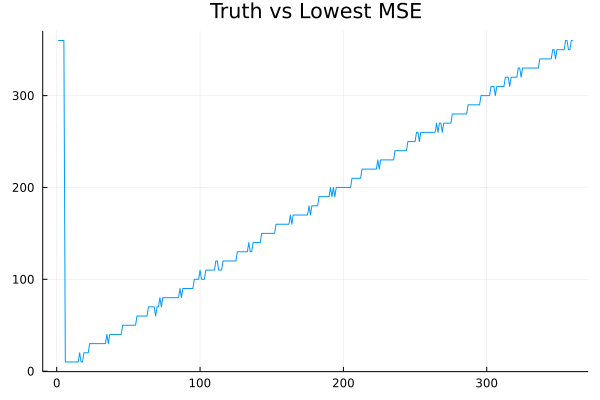

In [25]:
using Statistics
smallcircle= regularPoly(360,997,r);
smallcircleV = matToVector(smallcircle);
plotter = zeros(360)
loss = zeros(360);
for i in 1:360
    plotter[i],loss=LookUpAngle(l,t,measureAntennaArrayReduced(ALv,smallcircleV[i],88e6))
end
#plotter[1:90],plotter[91:360]=plotter[271:360],plotter[1:270]
#plotter[1:359],plotter[360]=plotter[2:360],plotter[1]

plot(circshift(plotter,89), title = "Truth vs Lowest MSE", legend = false)

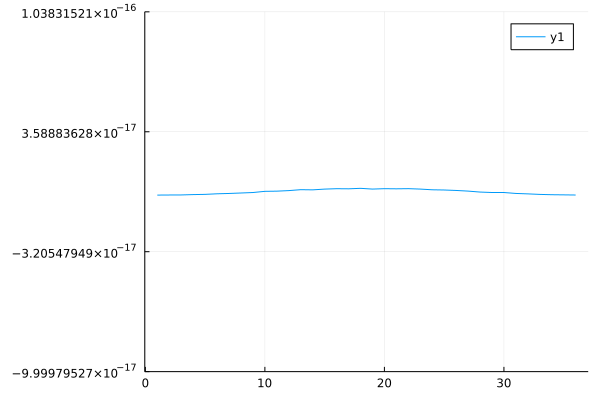

In [26]:
plot(loss)

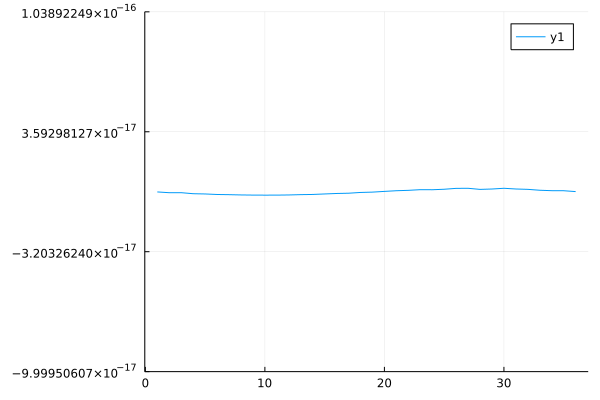

In [27]:
psefgsd,loss2=LookUpAngle(l,t,measureAntennaArray(ALv,smallcircleV[90],f))
plot(loss2)

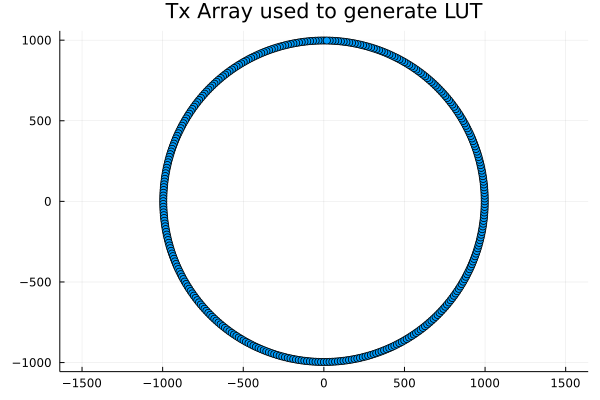

In [30]:
Txplot=plot(smallcircle[:,1], smallcircle[:,2], seriestype = :scatter, title = "Tx Array used to generate LUT",aspectratio=:equal,legend=false)


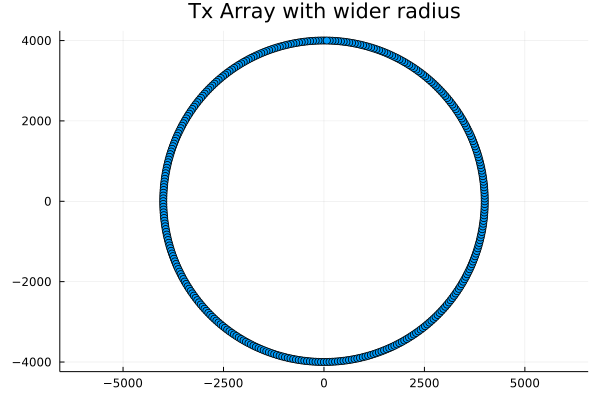

In [31]:
mediumcircle= regularPoly(360,4000,r);
mediumcircleV = matToVector(mediumcircle);
Txplot2=plot(mediumcircle[:,1], mediumcircle[:,2], seriestype = :scatter, title = "Tx Array with wider radius",aspectratio=:equal,legend=false)


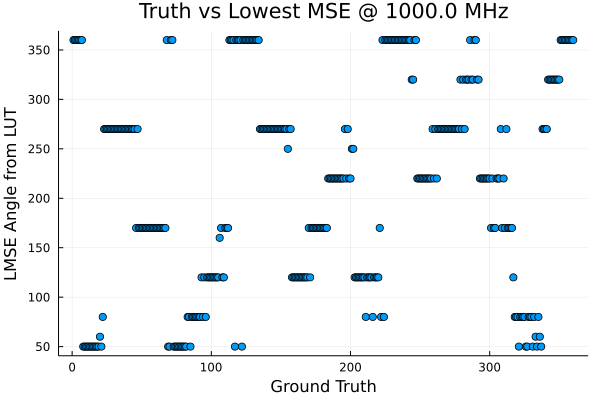

In [32]:
ftest=1000e6
loss = [zeros(360) for _ in 1:360]
for i in 1:360
    plotter[i],loss[i]=LookUpAngle(l,t,measureAntennaArrayReduced(ALv,mediumcircleV[i],ftest))
end
#plotter[1:90],plotter[91:360]=plotter[271:360],plotter[1:270]
#plotter[1:359],plotter[360]=plotter[2:360],plottwer[1]

plot(circshift(plotter,89), title = "Truth vs Lowest MSE @ "*string(ftest/1e6)*" MHz", legend = false,seriestype=:scatter,xlabel="Ground Truth",ylabel="LMSE Angle from LUT")

In [33]:
@show LookUpAngle(l,t,measureAntennaArray(ALv,smallcircleV[1],100e6));
println()
@show smallcircleV[1];
println();
@show testPOs = [0,500,179];
println();
@show LookUpAngle(l,t,measureAntennaArray(ALv,testPOs,100e6));

LookUpAngle(l, t, measureAntennaArray(ALv, smallcircleV[1], 1.0e8)) = (79.99999999999964, [2.330805858219482e-20, 5.634966681135651e-20, 1.1524826465800052e-19, 2.604358625012239e-19, 3.7852175007605856e-19, 6.728200432276923e-19, 8.364042029121206e-19, 1.0508905304624185e-18, 1.270966396488349e-18, 1.8860892944137092e-18, 1.960562210750112e-18, 2.214010942505662e-18, 2.6795604841533336e-18, 2.559116419062956e-18, 2.926455086143053e-18, 3.1210209046474087e-18, 3.0485387486108494e-18, 3.2811086518852922e-18, 2.8801069246926034e-18, 3.085703057349873e-18, 3.0130821094552507e-18, 3.0963447791440297e-18, 2.884462044873122e-18, 2.5282848041501254e-18, 2.4248975301324865e-18, 2.222009485061925e-18, 1.906484715891002e-18, 1.406970782907695e-18, 1.2013368195156628e-18, 1.233191787350973e-18, 7.754772825622865e-19, 5.670643551036066e-19, 3.0039279816557575e-19, 1.5945959930876315e-19, 1.0775060055156371e-19, 1.9081314970482566e-20])

smallcircleV[1] = [0.8426966292134831, 997.8426966292135, 0.0

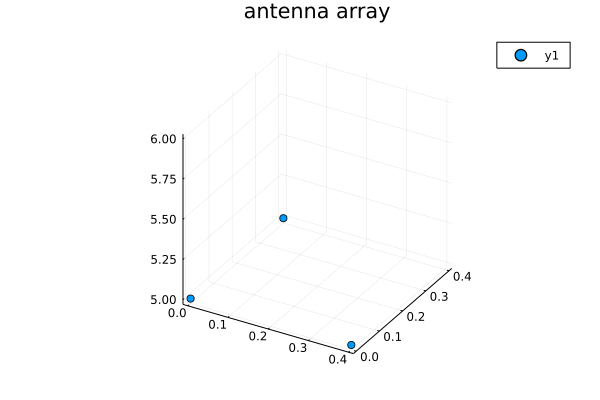

In [34]:

x = [smallcircleV[i][1] for i in 1:360],[smallcircleV[i][2] for i in 1:360],[smallcircleV[i][3] for i in 1:360]
y = [ALv[i][1] for i in 1:numAntennas],[ALv[i][2] for i in 1:numAntennas],[5 for i in 1:numAntennas]
plot(y,title="antenna array" ,seriestype = :scatter)

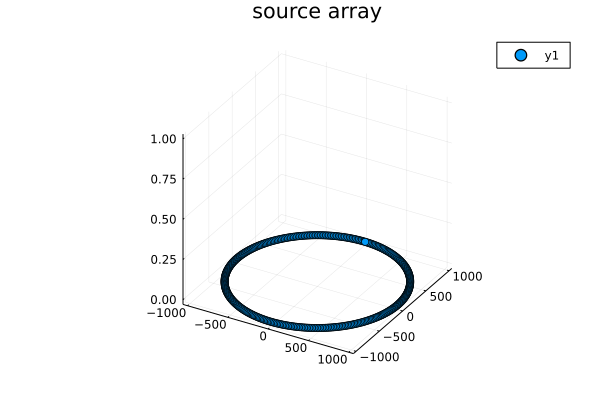

In [35]:
plot(x,title="source array" ,seriestype = :scatter)

In [36]:
plot([1,2,3])
ALv

3-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [0.0, 0.4, 0.0]
 [0.4, 0.0, 0.0]

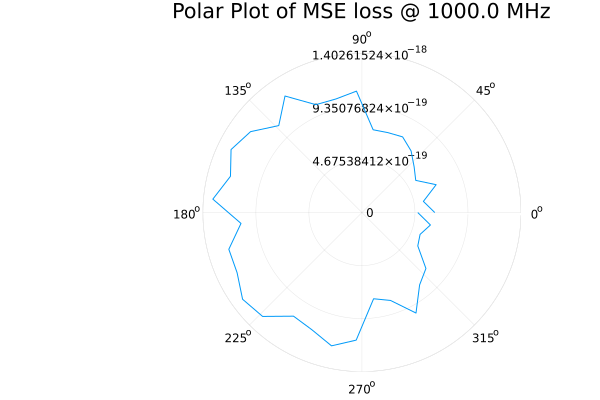

In [37]:
using Plots

ts = range(0, 2pi, length=36)
plot(ts,loss[1], proj=:polar, legend=false,title="Polar Plot of MSE loss @ "*string(ftest/1e6)*" MHz")

# For plotting the LUT values

In [38]:
l1=zeros(36)
l2 = zeros(36)

for I= 1:36
    l1[I]=l[I][1]
    l2[I]=l[I][2]

   
end

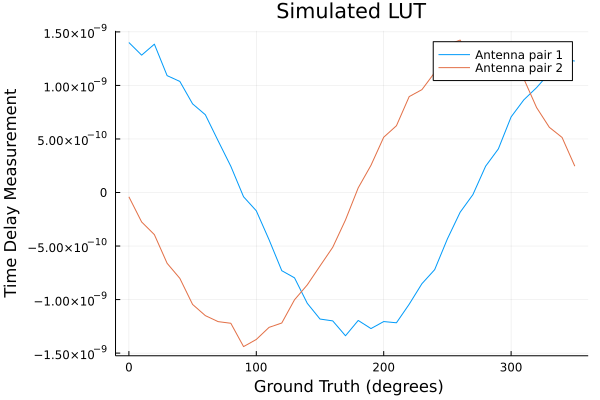

In [49]:
plot([0:10:350],l1,title="LUT values",xlabel="Ground Truth (degrees)",ylabel="Time Delay Measurement",label="Antenna pair 1")
plot!([0:10:350],l2,title="Simulated LUT",xlabel="Ground Truth (degrees) ",ylabel="Time Delay Measurement",label="Antenna pair 2")
